# Завдання на використання SQL в Python

1.Встановіть бібліотеку `mysql-connector-python` через pip aбо через conda.

In [1]:
!pip install mysql-connector-python

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.5/27.5 MB 49.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 409.8/409.8 kB 23.7 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.20.3
    Uninstalling protobuf-3.20.3:
      Successfully uninstalled protobuf-3.20.3


In [2]:
import mysql.connector as mysql
from mysql.connector.connection import MySQLConnection

2.В змінній `con` створіть підключення до бази даних employees за аналогією того, як це робилось в лекції:

In [3]:
con = mysql.connect(
    user='user1',
    password='7oygWy6P',
    host='3.68.62.36',
    database='employees'
)

3.Виберіть максимальну і мінімальну дати найму співробітників використовуючи `con.cursor()`. Аби отримати результати в кінці, виконайте `cursor.fetchall()`.

In [4]:
cursor = con.cursor()

In [5]:
sql = '''
SELECT MAX(hire_date) AS max_dt, MIN(hire_date) AS min_dt FROM employees
'''

cursor.execute(sql)

In [6]:
cursor.fetchall()

[(datetime.date(2000, 1, 28), datetime.date(1985, 1, 1))]

Очікуваний результат:  
    `[(datetime.date(2000, 1, 28), datetime.date(1985, 1, 1))]`

4.Давайте зберемо інформацію про останню ЗП кожного співробіткника в базі. З використанням `con.cursor()` виберіть з таблиці `salaries` для кожного співробітника його номер, останню в базі даних (тобто ту, що відповідає найновішій `to_date`) ЗП, та значення `from_date`, `to_date` для цієї ЗП.

Результати запишіть у pandas DataFrame, який збережіть у змінну `res`. Як взяти з курсора назви колонок - вже наведено. На екран виведіть назви колонок в змінній `res`, розмір цього датафрейму та перші 3 записи в ньому.

УВАГА! Зверніть увагу, що ЗП може оновлюватись протягом одного дня, тобто є випадки, коли апдейт ЗП був в певний день, скажімо 2001-01-01 і потім стався ще один апдейт ЗП цьому співробітнику цього самого дня. Запит має це враховувати.
Також, теоретично ЗП може бути зменшена. Тож, брати дату з максимальною ЗП буде неправильно з точки зору бізнес логіки. Треба саме останнє історичне значення ЗП кожного співробітника.

In [7]:
import pandas as pd
import warnings

warnings.filterwarnings('ignore')

In [8]:
sql = '''
SELECT emp_no, salary, from_date, to_date
FROM (
    SELECT emp_no, salary, from_date, to_date,
           ROW_NUMBER() OVER (PARTITION BY emp_no ORDER BY to_date DESC, from_date DESC) AS n
    FROM salaries
) s
WHERE s.n = 1
'''

res = pd.read_sql(sql, con)

In [9]:
res.head(3)

,emp_no,salary,from_date,to_date
0,10001,88958,2002-06-22,9999-01-01
1,10002,72527,2001-08-02,9999-01-01
2,10003,43311,2001-12-01,9999-01-01


In [10]:
res.shape

(300024, 4)

In [11]:
field_names = [i[0] for i in cursor.description]

5.В утвореній вибірці в змінній `res` скільки значень `to_date` рівні `9999-01-01`, а скільки - ні? Увага! Для виконання цього завдання важливо розуміти, який тип даних у значень колонки `to_date`. Зʼясуйте це, і потім напишіть фільтр для виводу потрібного результату.

In [14]:
import datetime

print(
    'to_date == \'9999-01-01\' in',
    len(res[res['to_date'] == datetime.date(9999, 1, 1)]),
    'cases\nto_date != \'9999-01-01\' in',
    len(res[res['to_date'] != datetime.date(9999, 1, 1)]),
    'cases'
)

to_date == '9999-01-01' in 240124 cases
to_date != '9999-01-01' in 59900 cases


6.Виведіть візуально розподіл (гістограму) зарплат співробітників, які досі працюють в компанії, використовуючи результат попереднього завдання. Співробітниками, які досі працюють в компанії вважаємо тих, в кого to_date має значення 9999-01-01. Обовʼязково підпишіть графік і вісі.

Ці три завдання - приклад, як нам може бути зручно витягнути дані з бази певним запитом, а потім використати витягнуту вибірку у Python для подальшого аналізу.

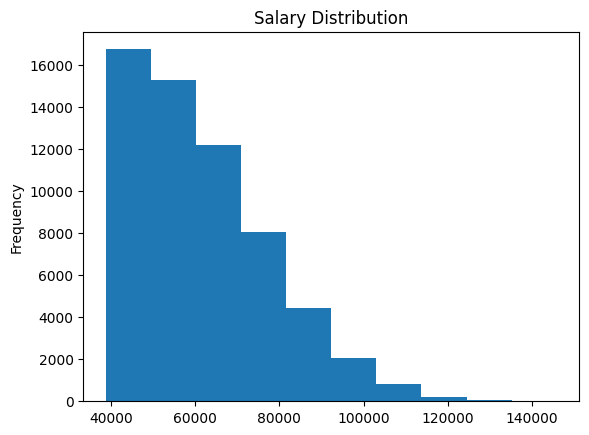

In [24]:
res[res['to_date'] != datetime.date(9999, 1, 1)]['salary'].plot(
    kind='hist',
    title='Salary Distribution'
    );

7.Виведіть кількість співробітників за роком, в який вони були найняті (`hire_date`) використовуючи `pandas.read_sql`. Запишіть результат в змінну `df` та виведіть значення змінної на екран.

In [29]:
sql_df = '''
SELECT YEAR(hire_date) AS hire_date, COUNT(DISTINCT emp_no) AS emp_num FROM employees
GROUP BY YEAR(hire_date)
'''

df = pd.read_sql(sql_df, con)

In [30]:
df

,hire_date,emp_num
0,1985,35316
1,1986,36150
2,1987,33501
3,1988,31436
4,1989,28394
5,1990,25610
6,1991,22568
7,1992,20402
8,1993,17772
9,1994,14835


8.Виведіть лінійний графік залежності кількості найманих співробітників від року найму. Ми ж не просто так дані з бази дістали :)
Перейменувати назви колонок датафрейму можна або методами pandas, або в sql запиті в попередньому завданні. Також, аби графік вийшов правильний, треба відсортувати роки за зростанням. І це також можна зробити аби в pandas, або в SQL.

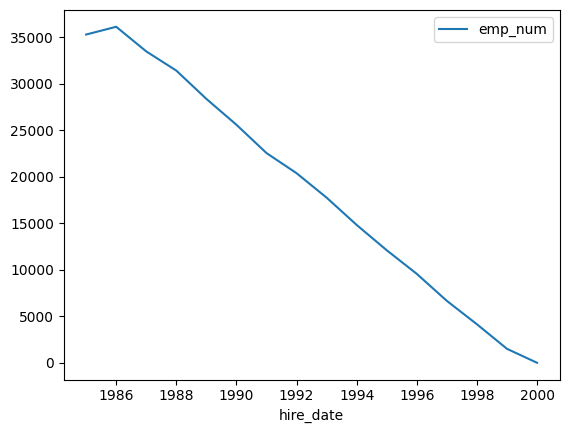

In [32]:
df.plot(
    x='hire_date',
    y='emp_num'
);

9.З допомогою SQL для робітників позиції `Engineer`, які вже не працюють в компанії (тобто у них є значення to_date, яке заповнено НЕ значенням за замовчанням) знайдіть кількість повних років перебування на позиції. Позиція зберігається в колонці `title` в таблиці `titles`. Кількість років перебування на позиції можна отримати наприклад з використанням функції `timestampdiff`. Ознайомтесь з її використанням в [документації](https://dev.mysql.com/doc/refman/8.0/en/date-and-time-functions.html#function_timestampdiff).

Результат запишіть в змінну `df_years` та виведіть цю змінну на екран.

In [33]:
sql_df_years = '''
SELECT emp_no,
timestampdiff(YEAR, from_date, to_date) AS duration
FROM titles
WHERE title = 'Engineer'
AND to_date != '9999-01-01'
'''

df_years = pd.read_sql(sql_df_years, con)

In [34]:
df_years

,emp_no,duration
0,10004,9
1,10009,5
2,10012,8
3,10018,8
4,10026,5
...,...,...
84015,499972,9
84016,499984,5
84017,499994,0
84018,499996,6


10.Використовуючи дані в  `df_years`, побудуйте гістограму кількості років, протягом яких люди з назвою позиції `Engineer` перебували на позиції. Не забудьте дати назву діаграмі, а також підписати вісі.

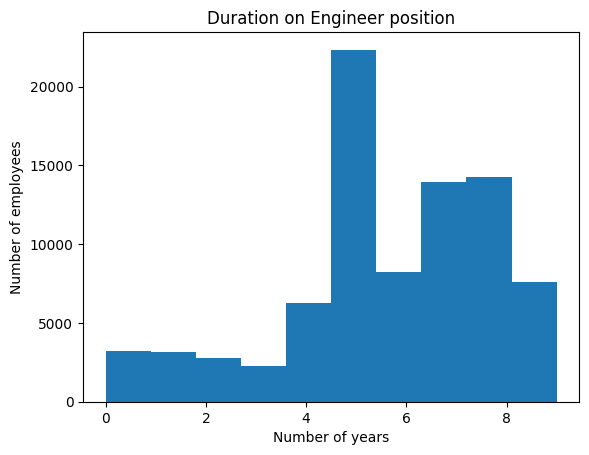

In [40]:
ax = df_years['duration'].plot(
    kind='hist',
    title='Duration on Engineer position'
)

ax.set_xlabel('Number of years')
ax.set_ylabel('Number of employees');

НЕ ЗАБУВАЄМО ЗАКРИТИ ПІДКЛЮЧЕННЯ ДО БАЗИ :)

In [41]:
con.close()